In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2

import tensorflow as tf
from keras.models import *
from keras.layers import *
# from keras.optimizers import Adam
from keras.models import model_from_json
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input

# Dataset

In [ ]:
# getting the labels corresponding to the image
label_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VCS/project/labels.csv')
label_df.columns = ['id' , 'people']
labels = np.array(label_df['people'])
label_df.head()

,id,people
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


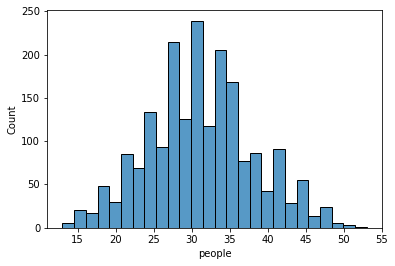

In [ ]:
sns.histplot(label_df['people'])

In [ ]:
# loading the images in vector format
img_orgin = np.load('/content/drive/MyDrive/Colab Notebooks/VCS/project/images.npy')
print(img_orgin.shape)

(2000, 480, 640, 3)


**测试先用少点数据**

In [ ]:
# img_orgin = img_orgin[:1000]
# labels = labels[:1000]

1620
200
180


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe1aa7e6690>,
 (-0.5, 639.5, 479.5, -0.5))

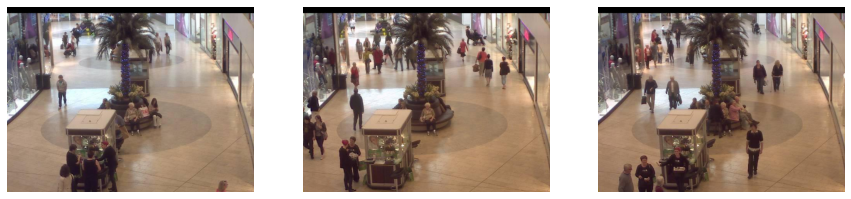

In [ ]:
# Split the dataset to train data, test data and validation data
x_train, x_test, y_train, y_test = train_test_split(img_orgin, labels, test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1)
print(x_train.shape[0])
print(x_test.shape[0])
print(x_validation.shape[0])

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1),plt.imshow(x_train[0]), plt.axis('off')
plt.subplot(1,3,2),plt.imshow(x_train[1]), plt.axis('off')
plt.subplot(1,3,3),plt.imshow(x_train[2]), plt.axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe1aa6d6f90>,
 (-0.5, 223.5, 223.5, -0.5))

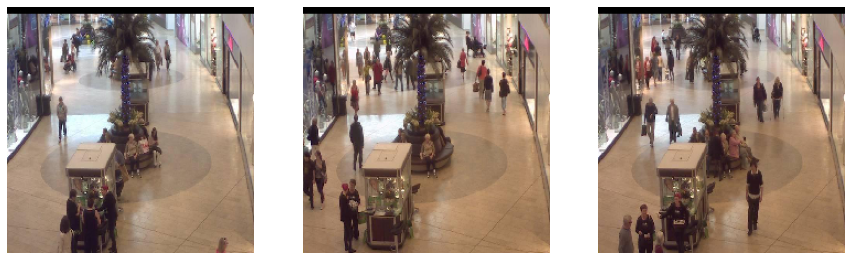

In [ ]:
# resize the image
H = 224
W = 224
x_train = tf.image.resize(x_train, [H,W], method='nearest')
x_test = tf.image.resize(x_test, [H,W], method='nearest')
x_validation = tf.image.resize(x_validation, [H,W], method='nearest')

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1),plt.imshow(x_train[0]), plt.axis('off')
plt.subplot(1,3,2),plt.imshow(x_train[1]), plt.axis('off')
plt.subplot(1,3,3),plt.imshow(x_train[2]), plt.axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe1a00fc210>,
 (-0.5, 223.5, 223.5, -0.5))

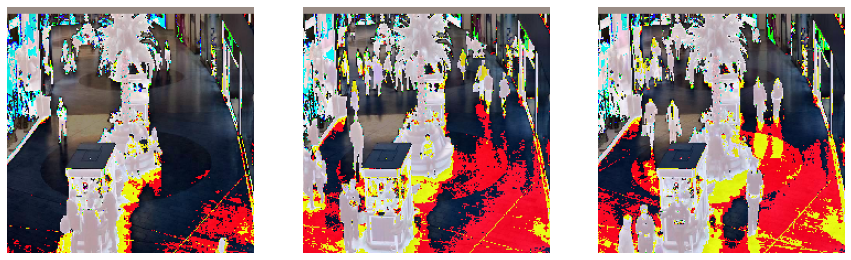

In [ ]:
# x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
# x_validation = tf.keras.applications.resnet50.preprocess_input(x_validation)
# x_test = tf.keras.applications.resnet50.preprocess_input(x_test)
x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_validation = tf.keras.applications.vgg16.preprocess_input(x_validation)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)
c = x_train[0]

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1),plt.imshow(x_train[0]), plt.axis('off')
plt.subplot(1,3,2),plt.imshow(x_train[1]), plt.axis('off')
plt.subplot(1,3,3),plt.imshow(x_train[2]), plt.axis('off')

In [ ]:
# standardize the pixel values is good for gradient descent
# x_train = tf.image.per_image_standardization(x_train)
# x_test = tf.image.per_image_standardization(x_test)
# x_validation = tf.image.per_image_standardization(x_validation)

# plt.figure(figsize=(5, 5))
# plt.imshow(x_train[0]), plt.axis('off')

# Model base on VGG16 

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(7,5))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')
  plt.grid(True)
  # plt.legend()

def plot_mae(history):
  plt.figure(figsize=(7,5))
  plt.plot(history.epoch,history.history['mae'])
  plt.plot(history.epoch,history.history['val_mae'])
  plt.title('mae')
  plt.grid(True)
  # plt.legend()

In [ ]:
base_model = VGG16(weights='imagenet', input_shape=(H,W,3) ,include_top=False, pooling=False)
for layer in base_model.layers:
  layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Train with 112*112 images

### vgg16-1

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.4)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# model_base_vgg16.summary()

In [ ]:
model_base_vgg16.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_vgg16.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 3s 25ms/step - loss: 494.0656 - mae: 17.4539 - val_loss: 115.5905 - val_mae: 8.4378
Epoch 2/20
102/102 [==============================] - 2s 22ms/step - loss: 222.5389 - mae: 11.7023 - val_loss: 81.3140 - val_mae: 7.2729
Epoch 3/20
102/102 [==============================] - 2s 23ms/step - loss: 136.1513 - mae: 9.2739 - val_loss: 43.1300 - val_mae: 5.1856
Epoch 4/20
102/102 [==============================] - 2s 22ms/step - loss: 85.2585 - mae: 7.3346 - val_loss: 42.0293 - val_mae: 5.3342
Epoch 5/20
102/102 [==============================] - 2s 22ms/step - loss: 63.3497 - mae: 6.2642 - val_loss: 27.7435 - val_mae: 4.2366
Epoch 6/20
102/102 [==============================] - 2s 23ms/step - loss: 48.1037 - mae: 5.5192 - val_loss: 27.7824 - val_mae: 4.2059
Epoch 7/20
102/102 [==============================] - 2s 22ms/step - loss: 42.6584 - mae: 5.1526 - val_loss: 24.0768 - val_mae: 3.8554
Epoch 8/20
102/102 [=============================

mae:3.764133930206299


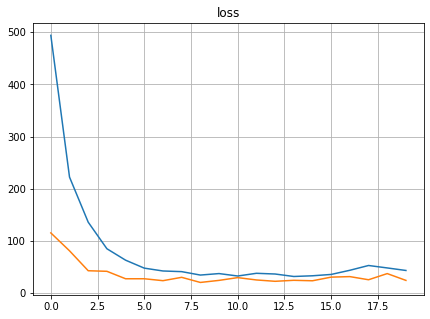

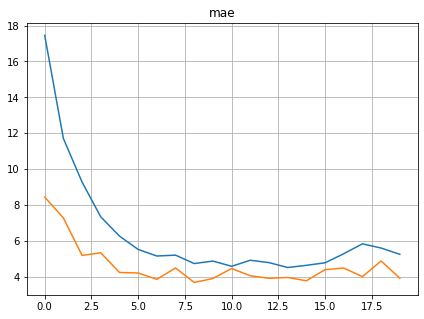

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_vgg16.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

### vgg16-2

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.4)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_base_vgg16.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

In [ ]:
model_base_vgg16.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_vgg16.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 3s 26ms/step - loss: 528.6044 - mae: 15.0697 - val_loss: 38.1294 - val_mae: 4.9791
Epoch 2/20
102/102 [==============================] - 2s 23ms/step - loss: 69.0721 - mae: 6.5625 - val_loss: 23.7735 - val_mae: 3.7400
Epoch 3/20
102/102 [==============================] - 2s 23ms/step - loss: 38.8984 - mae: 5.0035 - val_loss: 27.4244 - val_mae: 4.2499
Epoch 4/20
102/102 [==============================] - 2s 23ms/step - loss: 29.8918 - mae: 4.3483 - val_loss: 17.6472 - val_mae: 3.2546
Epoch 5/20
102/102 [==============================] - 2s 23ms/step - loss: 22.4214 - mae: 3.7873 - val_loss: 18.2357 - val_mae: 3.4640
Epoch 6/20
102/102 [==============================] - 2s 23ms/step - loss: 20.1846 - mae: 3.5685 - val_loss: 15.5696 - val_mae: 3.1902
Epoch 7/20
102/102 [==============================] - 2s 23ms/step - loss: 14.8368 - mae: 3.0539 - val_loss: 14.1387 - val_mae: 2.9110
Epoch 8/20
102/102 [==============================] -

mae:2.7817156314849854


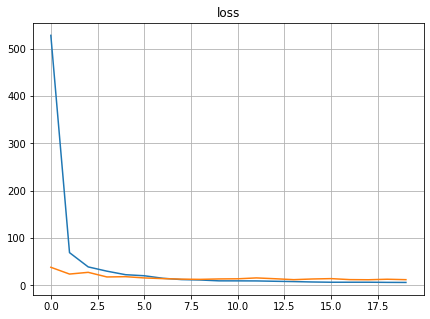

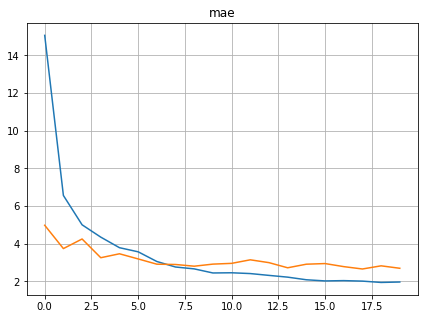

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_vgg16.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

### vgg16-3

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.4)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_base_vgg16.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

In [ ]:
model_base_vgg16.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_vgg16.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 4s 28ms/step - loss: 696.2243 - mae: 11.9734 - val_loss: 24.1430 - val_mae: 3.7428
Epoch 2/20
102/102 [==============================] - 2s 23ms/step - loss: 26.2956 - mae: 4.0828 - val_loss: 17.1972 - val_mae: 3.0819
Epoch 3/20
102/102 [==============================] - 2s 24ms/step - loss: 19.4481 - mae: 3.5153 - val_loss: 16.9206 - val_mae: 3.0764
Epoch 4/20
102/102 [==============================] - 2s 24ms/step - loss: 15.4371 - mae: 3.1178 - val_loss: 16.0122 - val_mae: 3.1721
Epoch 5/20
102/102 [==============================] - 2s 23ms/step - loss: 13.9100 - mae: 2.9696 - val_loss: 13.4907 - val_mae: 2.8757
Epoch 6/20
102/102 [==============================] - 2s 24ms/step - loss: 10.3542 - mae: 2.5728 - val_loss: 12.6826 - val_mae: 2.7458
Epoch 7/20
102/102 [==============================] - 2s 24ms/step - loss: 9.6776 - mae: 2.4659 - val_loss: 12.3952 - val_mae: 2.7163
Epoch 8/20
102/102 [==============================] - 

mae:2.868335008621216


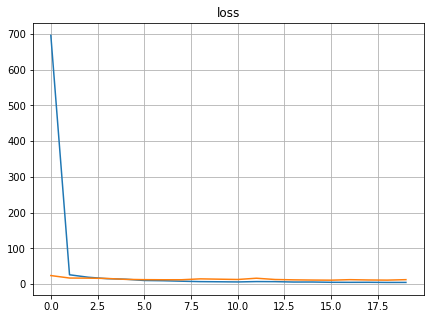

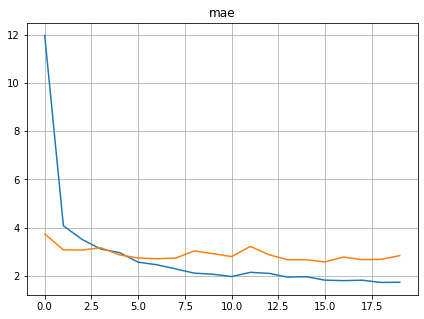

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_vgg16.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

### vgg16-4

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.4)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_base_vgg16.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0  

In [ ]:
model_base_vgg16.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_vgg16.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 4s 30ms/step - loss: 229.4804 - mae: 7.5567 - val_loss: 16.9116 - val_mae: 3.2385
Epoch 2/20
102/102 [==============================] - 3s 26ms/step - loss: 25.5880 - mae: 3.9882 - val_loss: 14.7883 - val_mae: 3.1067
Epoch 3/20
102/102 [==============================] - 3s 26ms/step - loss: 16.7428 - mae: 3.2405 - val_loss: 15.6393 - val_mae: 3.1859
Epoch 4/20
102/102 [==============================] - 3s 26ms/step - loss: 13.0889 - mae: 2.8080 - val_loss: 12.1789 - val_mae: 2.7863
Epoch 5/20
102/102 [==============================] - 3s 26ms/step - loss: 9.2454 - mae: 2.3981 - val_loss: 11.7172 - val_mae: 2.7849
Epoch 6/20
102/102 [==============================] - 3s 26ms/step - loss: 9.7622 - mae: 2.4711 - val_loss: 22.3055 - val_mae: 3.8300
Epoch 7/20
102/102 [==============================] - 3s 26ms/step - loss: 9.7847 - mae: 2.4630 - val_loss: 14.6822 - val_mae: 2.9750
Epoch 8/20
102/102 [==============================] - 3s 

mae:2.5653631687164307


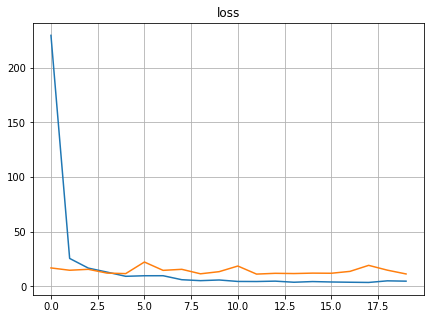

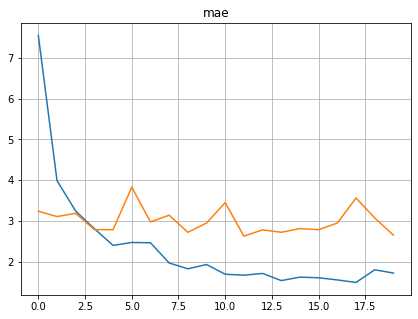

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_vgg16.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

In [ ]:
model_base_vgg16.save('my_vgg16_112.h5')

## Train with 224*224 images

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.4)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_base_vgg16.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
model_base_vgg16.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_vgg16.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 9s 78ms/step - loss: 636.4548 - mae: 8.3367 - val_loss: 13.0602 - val_mae: 2.8425
Epoch 2/20
102/102 [==============================] - 8s 75ms/step - loss: 16.7910 - mae: 3.2134 - val_loss: 13.1298 - val_mae: 2.9038
Epoch 3/20
102/102 [==============================] - 8s 75ms/step - loss: 14.6524 - mae: 3.0558 - val_loss: 13.3814 - val_mae: 2.9713
Epoch 4/20
102/102 [==============================] - 8s 76ms/step - loss: 11.5495 - mae: 2.6860 - val_loss: 7.8904 - val_mae: 2.2739
Epoch 5/20
102/102 [==============================] - 8s 76ms/step - loss: 10.5490 - mae: 2.5795 - val_loss: 13.3821 - val_mae: 2.8699
Epoch 6/20
102/102 [==============================] - 8s 77ms/step - loss: 8.8580 - mae: 2.3847 - val_loss: 6.4586 - val_mae: 2.0079
Epoch 7/20
102/102 [==============================] - 8s 77ms/step - loss: 7.0492 - mae: 2.0940 - val_loss: 8.9794 - val_mae: 2.4054
Epoch 8/20
102/102 [==============================] - 8s 78

mae:2.3076257705688477


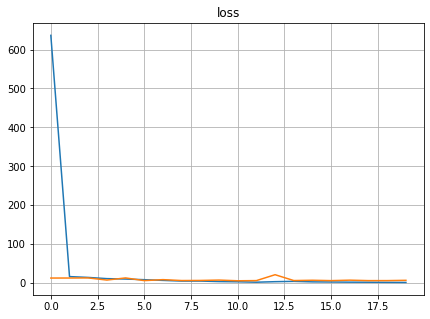

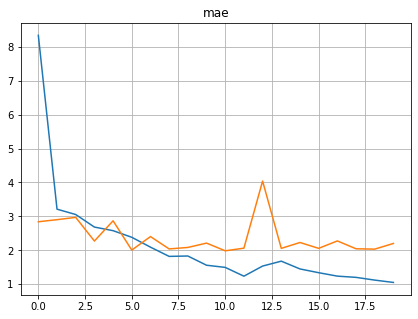

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_vgg16.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

In [ ]:
model_base_vgg16.save('my_vgg16_224.h5')
# load_model = tf.keras.models.load_model('my_vgg16_112.h5')

# Model base on ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', input_shape=(224,224,3) ,include_top=False, pooling='avg')
for layer in base_model.layers:
  layer.trainable = False 
# base_model.summary()

In [ ]:
print(f'The numbers of layers of Resnet50: {len(base_model.layers)}')

The numbers of layers of Resnet50: 176


### resnet50-1

In [ ]:
x = base_model.output
# x = RandomCrop(112,112,3)(x)
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.1)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# model_base_resnet50.summary()

In [ ]:
model_base_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_resnet50.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
51/51 [==============================] - 12s 150ms/step - loss: 79.0397 - mae: 6.6580 - val_loss: 25.0520 - val_mae: 4.1000
Epoch 2/20
51/51 [==============================] - 6s 123ms/step - loss: 23.3637 - mae: 3.9258 - val_loss: 20.6148 - val_mae: 3.7979
Epoch 3/20
51/51 [==============================] - 6s 124ms/step - loss: 18.7438 - mae: 3.4651 - val_loss: 18.1530 - val_mae: 3.5427
Epoch 4/20
51/51 [==============================] - 6s 125ms/step - loss: 16.3904 - mae: 3.1941 - val_loss: 12.9628 - val_mae: 2.9533
Epoch 5/20
51/51 [==============================] - 6s 125ms/step - loss: 15.5913 - mae: 3.1731 - val_loss: 13.7914 - val_mae: 3.1031
Epoch 6/20
51/51 [==============================] - 6s 125ms/step - loss: 11.7258 - mae: 2.7191 - val_loss: 13.2545 - val_mae: 3.0142
Epoch 7/20
51/51 [==============================] - 6s 125ms/step - loss: 11.0652 - mae: 2.6649 - val_loss: 10.3280 - val_mae: 2.5473
Epoch 8/20
51/51 [==============================] - 6s 125ms/

mae:2.7831151485443115


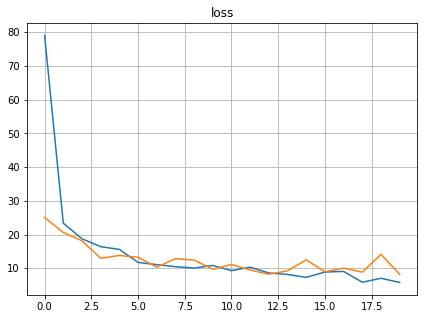

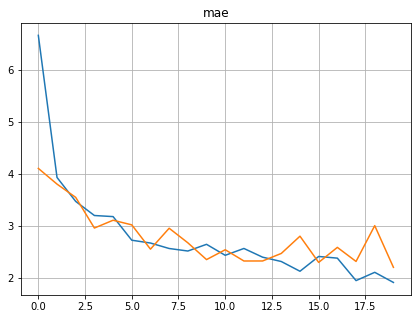

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_resnet50.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

### resnet50-2

In [ ]:
x = base_model.output
# x = RandomCrop(112,112,3)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.1)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# model_base_resnet50.summary()

In [ ]:
model_base_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_resnet50.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 11s 70ms/step - loss: 90.7394 - mae: 6.3989 - val_loss: 19.5904 - val_mae: 3.6030
Epoch 2/20
102/102 [==============================] - 6s 57ms/step - loss: 18.1692 - mae: 3.3798 - val_loss: 12.3659 - val_mae: 2.8608
Epoch 3/20
102/102 [==============================] - 6s 58ms/step - loss: 17.6489 - mae: 3.3339 - val_loss: 11.7457 - val_mae: 2.7046
Epoch 4/20
102/102 [==============================] - 6s 57ms/step - loss: 13.4519 - mae: 2.9289 - val_loss: 11.0331 - val_mae: 2.5891
Epoch 5/20
102/102 [==============================] - 6s 58ms/step - loss: 13.4201 - mae: 2.8984 - val_loss: 10.4280 - val_mae: 2.6180
Epoch 6/20
102/102 [==============================] - 6s 58ms/step - loss: 13.7797 - mae: 2.9510 - val_loss: 11.1839 - val_mae: 2.6632
Epoch 7/20
102/102 [==============================] - 6s 58ms/step - loss: 10.2073 - mae: 2.5616 - val_loss: 15.3464 - val_mae: 3.0945
Epoch 8/20
102/102 [==============================] - 

mae:2.4808132648468018


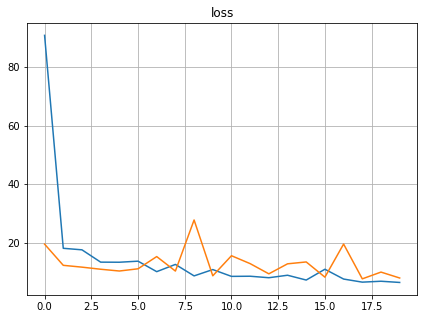

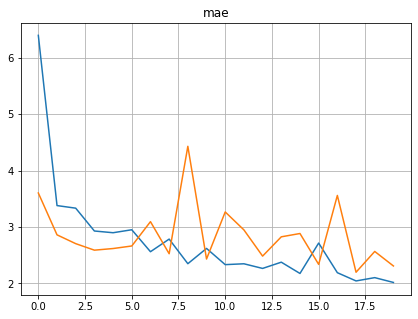

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_resnet50.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

### resnet50-3

In [ ]:
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)
# add dropout layer
x = Dropout(0.1)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# model_base_resnet50.summary()

In [ ]:
model_base_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_resnet50.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 18s 141ms/step - loss: 101.0530 - mae: 6.5057 - val_loss: 18.7504 - val_mae: 3.4759
Epoch 2/20
102/102 [==============================] - 13s 129ms/step - loss: 17.9700 - mae: 3.3574 - val_loss: 14.5864 - val_mae: 3.0441
Epoch 3/20
102/102 [==============================] - 13s 130ms/step - loss: 16.2955 - mae: 3.1936 - val_loss: 12.7510 - val_mae: 2.8251
Epoch 4/20
102/102 [==============================] - 13s 130ms/step - loss: 13.4187 - mae: 2.9077 - val_loss: 11.6169 - val_mae: 2.7213
Epoch 5/20
102/102 [==============================] - 13s 131ms/step - loss: 12.6077 - mae: 2.8071 - val_loss: 11.3674 - val_mae: 2.6613
Epoch 6/20
102/102 [==============================] - 13s 130ms/step - loss: 10.0947 - mae: 2.5018 - val_loss: 13.3804 - val_mae: 2.9089
Epoch 7/20
102/102 [==============================] - 13s 131ms/step - loss: 10.4821 - mae: 2.5926 - val_loss: 14.1868 - val_mae: 2.9829
Epoch 8/20
102/102 [====================

mae:2.459076166152954


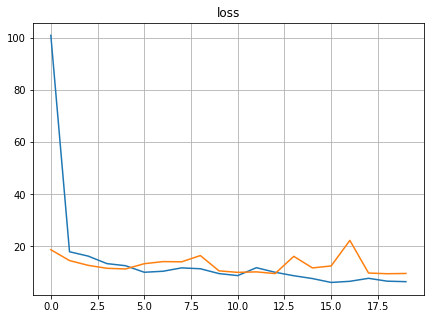

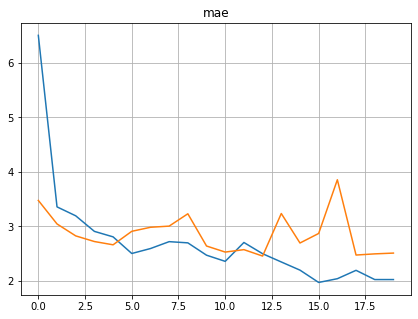

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_resnet50.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')

### resnet50-4

In [ ]:
x = base_model.output
# x = RandomCrop(112,112,3)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# add a flatten layer
x = Flatten()(x)
# add dropout layer
x = Dropout(0.1)(x)
predictions = Dense(1)(x)

# this is the model we will train
model_base_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# model_base_resnet50.summary()

In [ ]:
model_base_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [ ]:
start_time = time.time()
history = model_base_resnet50.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=20, batch_size=16)
end_time = time.time()
print(f'Training time:{end_time - start_time}')

Epoch 1/20
102/102 [==============================] - 10s 68ms/step - loss: 153.2912 - mae: 7.4872 - val_loss: 20.2075 - val_mae: 3.6728
Epoch 2/20
102/102 [==============================] - 6s 58ms/step - loss: 18.5365 - mae: 3.4149 - val_loss: 16.6651 - val_mae: 3.2772
Epoch 3/20
102/102 [==============================] - 6s 59ms/step - loss: 16.9929 - mae: 3.2763 - val_loss: 13.9834 - val_mae: 2.9634
Epoch 4/20
102/102 [==============================] - 6s 59ms/step - loss: 14.1928 - mae: 2.9607 - val_loss: 10.7531 - val_mae: 2.5914
Epoch 5/20
102/102 [==============================] - 6s 59ms/step - loss: 15.1147 - mae: 3.0836 - val_loss: 13.2159 - val_mae: 2.8888
Epoch 6/20
102/102 [==============================] - 6s 59ms/step - loss: 12.7612 - mae: 2.8101 - val_loss: 14.0953 - val_mae: 3.0514
Epoch 7/20
102/102 [==============================] - 6s 60ms/step - loss: 12.4176 - mae: 2.8284 - val_loss: 9.5243 - val_mae: 2.4701
Epoch 8/20
102/102 [==============================] - 

mae:2.3978161811828613


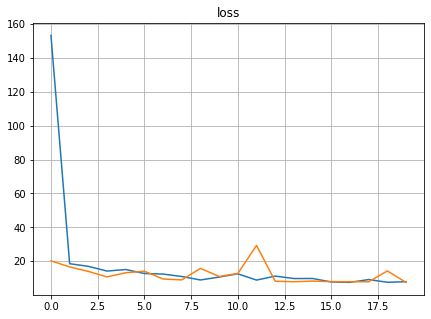

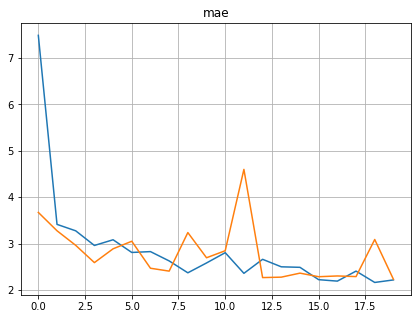

In [ ]:
plot_loss(history)
plot_mae(history)
scores = model_base_resnet50.evaluate(x_test, y_test, verbose=0)
print(f'mae:{scores[1]}')